## Step 1: Raw vs. Normalized Distributions (Box Plots)
**Goal:** Confirm if deeper layers naturally have higher variance/scores (biasing the ranking) and if normalization fixes this. Last time, we saw deeper layers were "louder."

In [1]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

H5_PATH = "../results/rankings_train_700.h5"

def load_and_summarize(path):
    data = []
    
    # Trackers for summary
    unique_layers = set()
    unique_metrics = set()
    total_kernels = 0
    n_images_detected = 0
    mean_iou = 0.0  # <--- NEW
    
    with h5py.File(path, 'r') as f:
        # 1. Get Metadata
        first_layer = list(f.keys())[0]
        if 'iou_scores' in f:
            iou_data = f['iou_scores'][:]
            n_images_detected = iou_data.shape[0]
            mean_iou = np.mean(iou_data) # <--- NEW: Calculate Mean
            
        for layer in f.keys():
            # Skip non-layer datasets
            if layer in ['iou_scores', 'image_names']: continue
            
            unique_layers.add(layer)
            
            # Count kernels in this layer (using any metric dataset)
            # Filter out 'raw_gap' which is the raw vector, not a rank score
            ranking_metrics = [k for k in f[layer].keys() if k != 'raw_gap']
            
            if len(ranking_metrics) > 0:
                n_kernels_in_layer = f[layer][ranking_metrics[0]].shape[0]
                total_kernels += n_kernels_in_layer
                
                for m in ranking_metrics:
                    unique_metrics.add(m)
            
            # Load Data
            for metric in ranking_metrics:
                scores = f[layer][metric][:]
                
                # Z-Score Normalization (Robust)
                if scores.std() == 0:
                    z_scores = np.zeros_like(scores)
                else:
                    z_scores = (scores - scores.mean()) / scores.std()
                
                for idx, (val, z_val) in enumerate(zip(scores, z_scores)):
                    data.append({
                        # Create a robust unique ID: "LayerName:Index"
                        'Unique_ID': f"{layer}:{idx}", 
                        'Layer': layer,
                        'Channel': idx,                 
                        'Metric': metric,
                        'Raw_Score': val,
                        'Norm_Score': z_val
                    })
                    
    # Print Summary
    print(f"--- Dataset Summary ---")
    print(f"File Source:      {path}")
    print(f"Images Analyzed:  {n_images_detected}")
    print(f"Mean IoU:         {mean_iou:.4f}") 
    print(f"Total Layers:     {len(unique_layers)}")
    print(f"Total Kernels:    {total_kernels}")
    print(f"Metrics Found:    {list(unique_metrics)}")
    print("-----------------------")
    
    return pd.DataFrame(data)

df = load_and_summarize(H5_PATH)

--- Dataset Summary ---
File Source:      ../results/rankings_train_700.h5
Images Analyzed:  723
Mean IoU:         0.9360
Total Layers:     34
Total Kernels:    8192
Metrics Found:    ['ranking_dynamic_variance', 'ranking_centrality', 'ranking_pls', 'ranking_static_variance', 'ranking_pca']
-----------------------


--- RAW SCORE DISTRIBUTIONS (Note the Scale Differences) ---


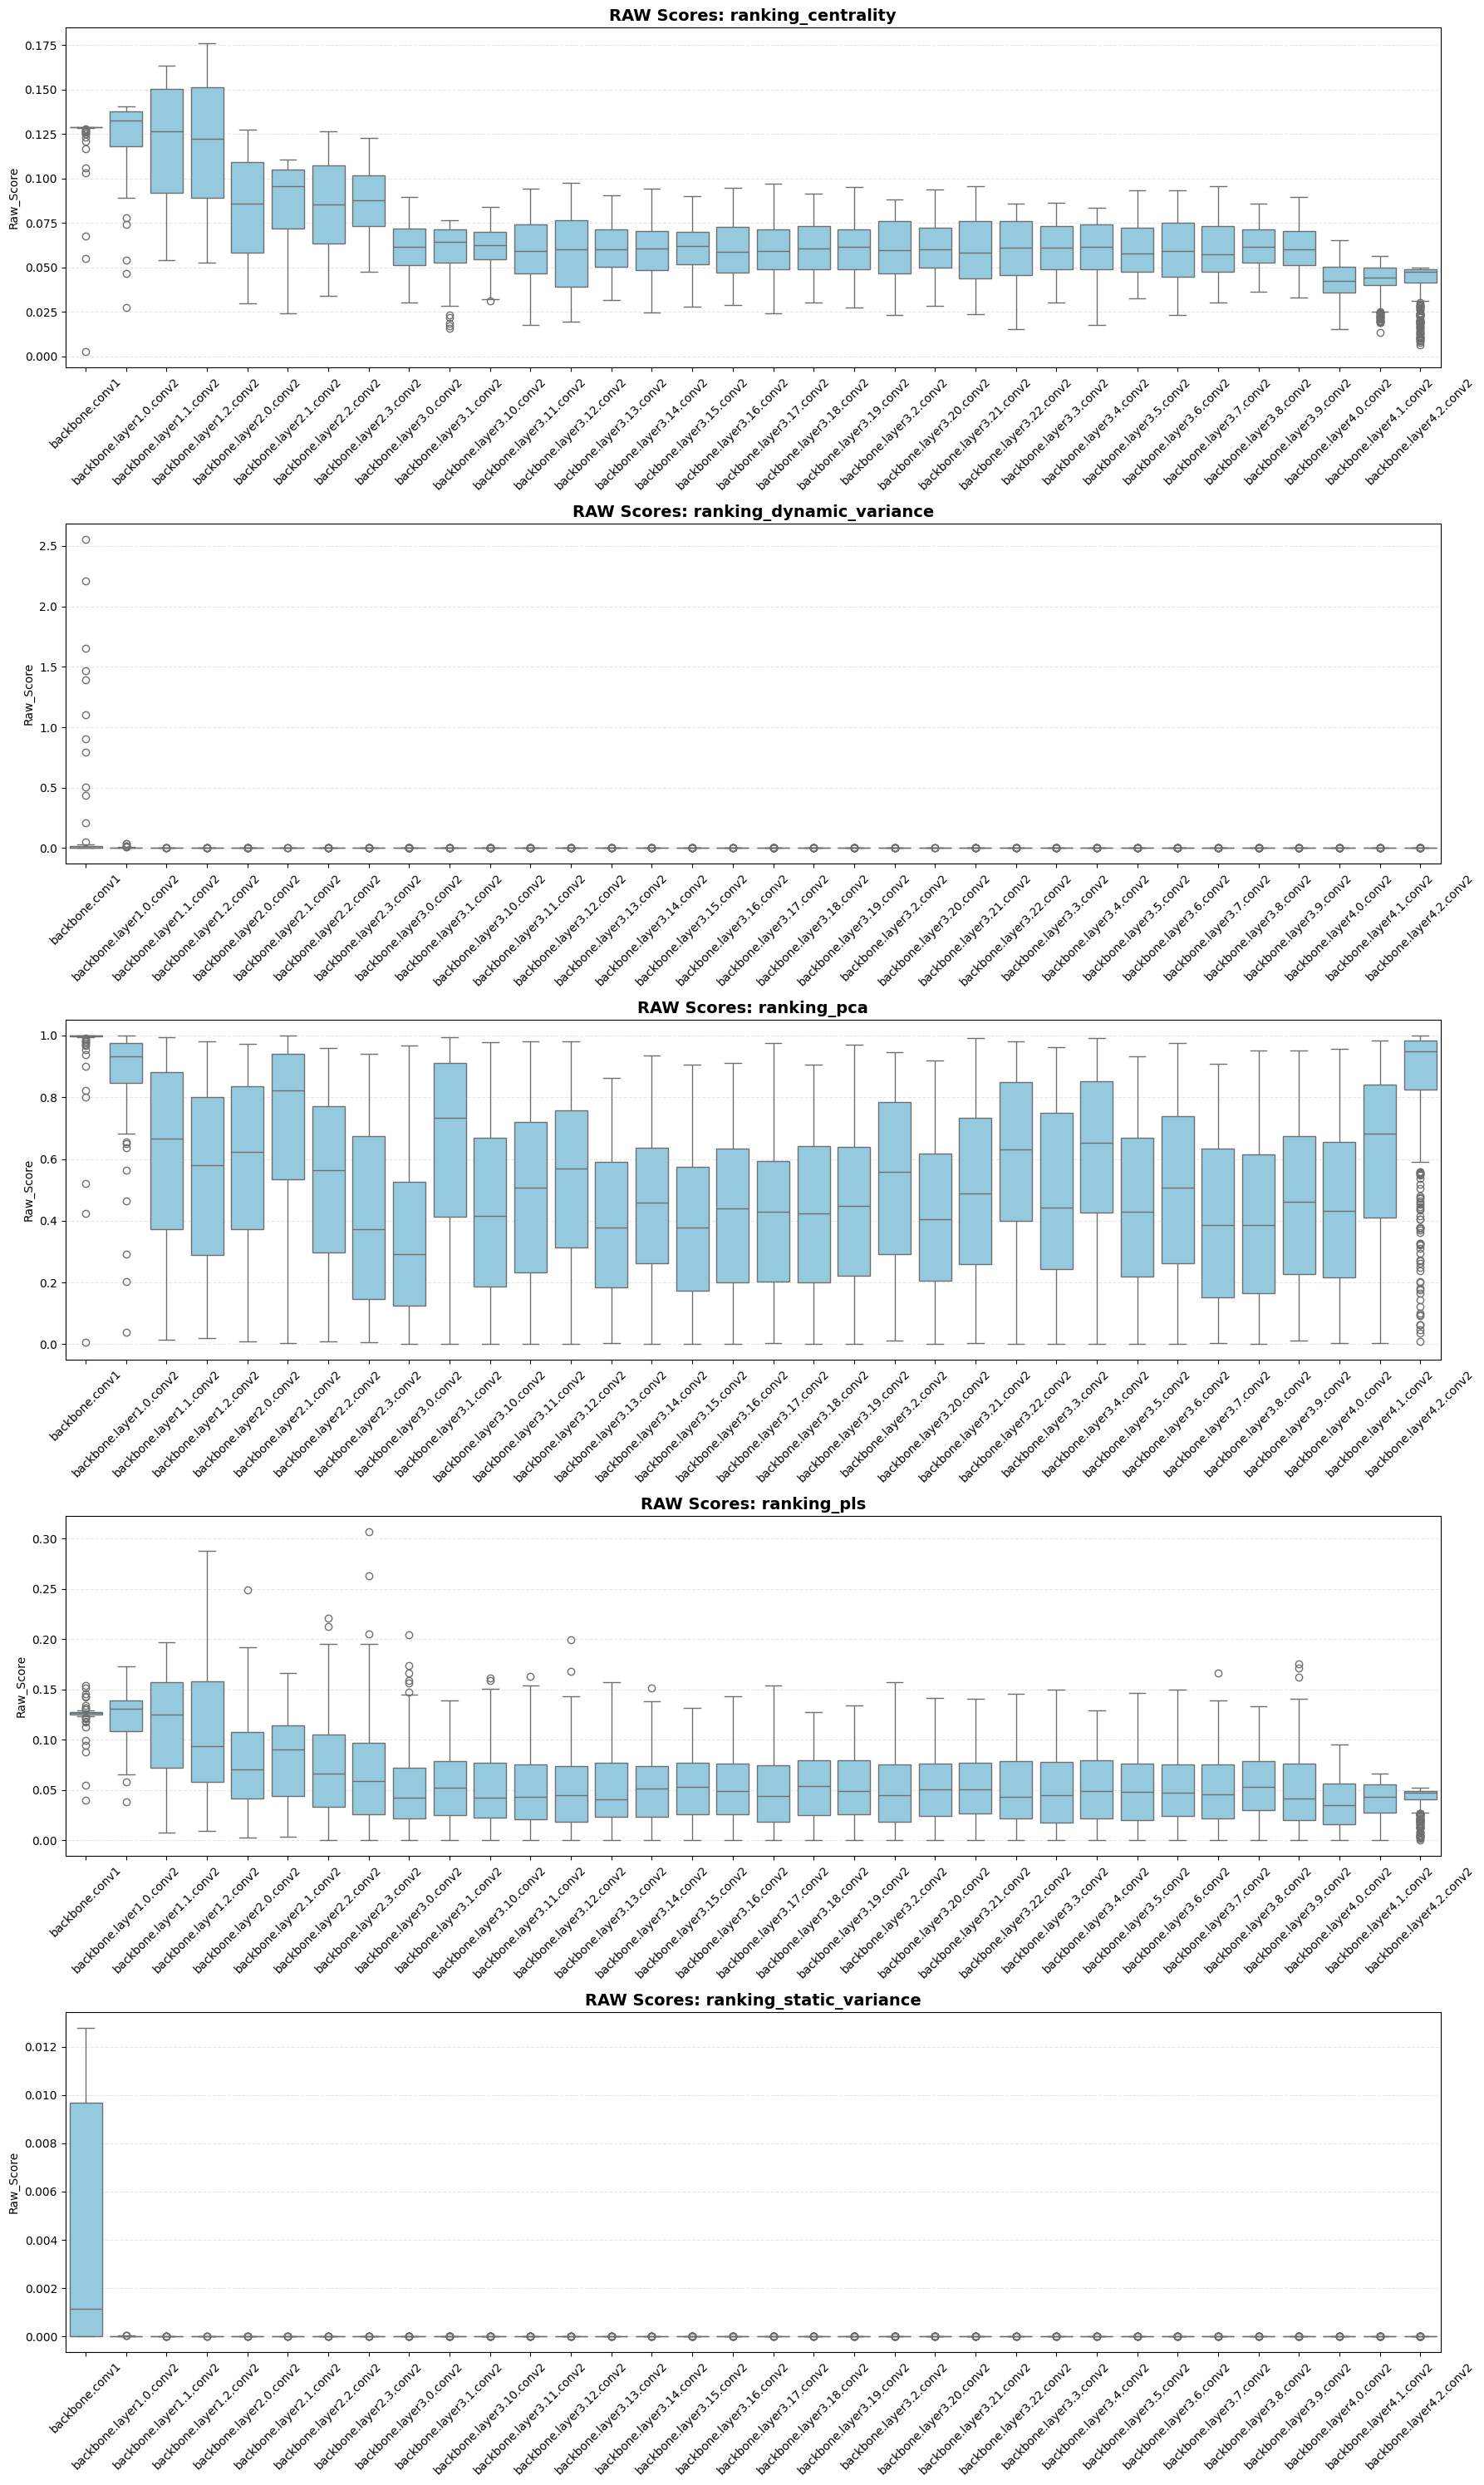

In [2]:
# --- CELL 2: RAW SCORES ---
metrics = df['Metric'].unique()
fig, axes = plt.subplots(len(metrics), 1, figsize=(18, 6 * len(metrics)))

# Sort data once to ensure consistent X-axis order
try:
    df['sort_key'] = df['Layer'].apply(lambda x: int(x.split('.')[2]) if 'layer' in x else -1)
    df_sorted = df.sort_values(['Layer', 'sort_key'])
except:
    df_sorted = df.sort_values('Layer')

print("--- RAW SCORE DISTRIBUTIONS (Note the Scale Differences) ---")

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    subset = df_sorted[df_sorted['Metric'] == metric]
    
    sns.boxplot(data=subset, x='Layer', y='Raw_Score', ax=ax, color='skyblue')
    
    ax.set_title(f"RAW Scores: {metric}", fontsize=14, fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, axis='y', linestyle='--', alpha=0.3)
    ax.set_xlabel("") # Remove x-label to reduce clutter

plt.tight_layout()
plt.show()

--- NORMALIZED DISTRIBUTIONS (Z-Scores) ---


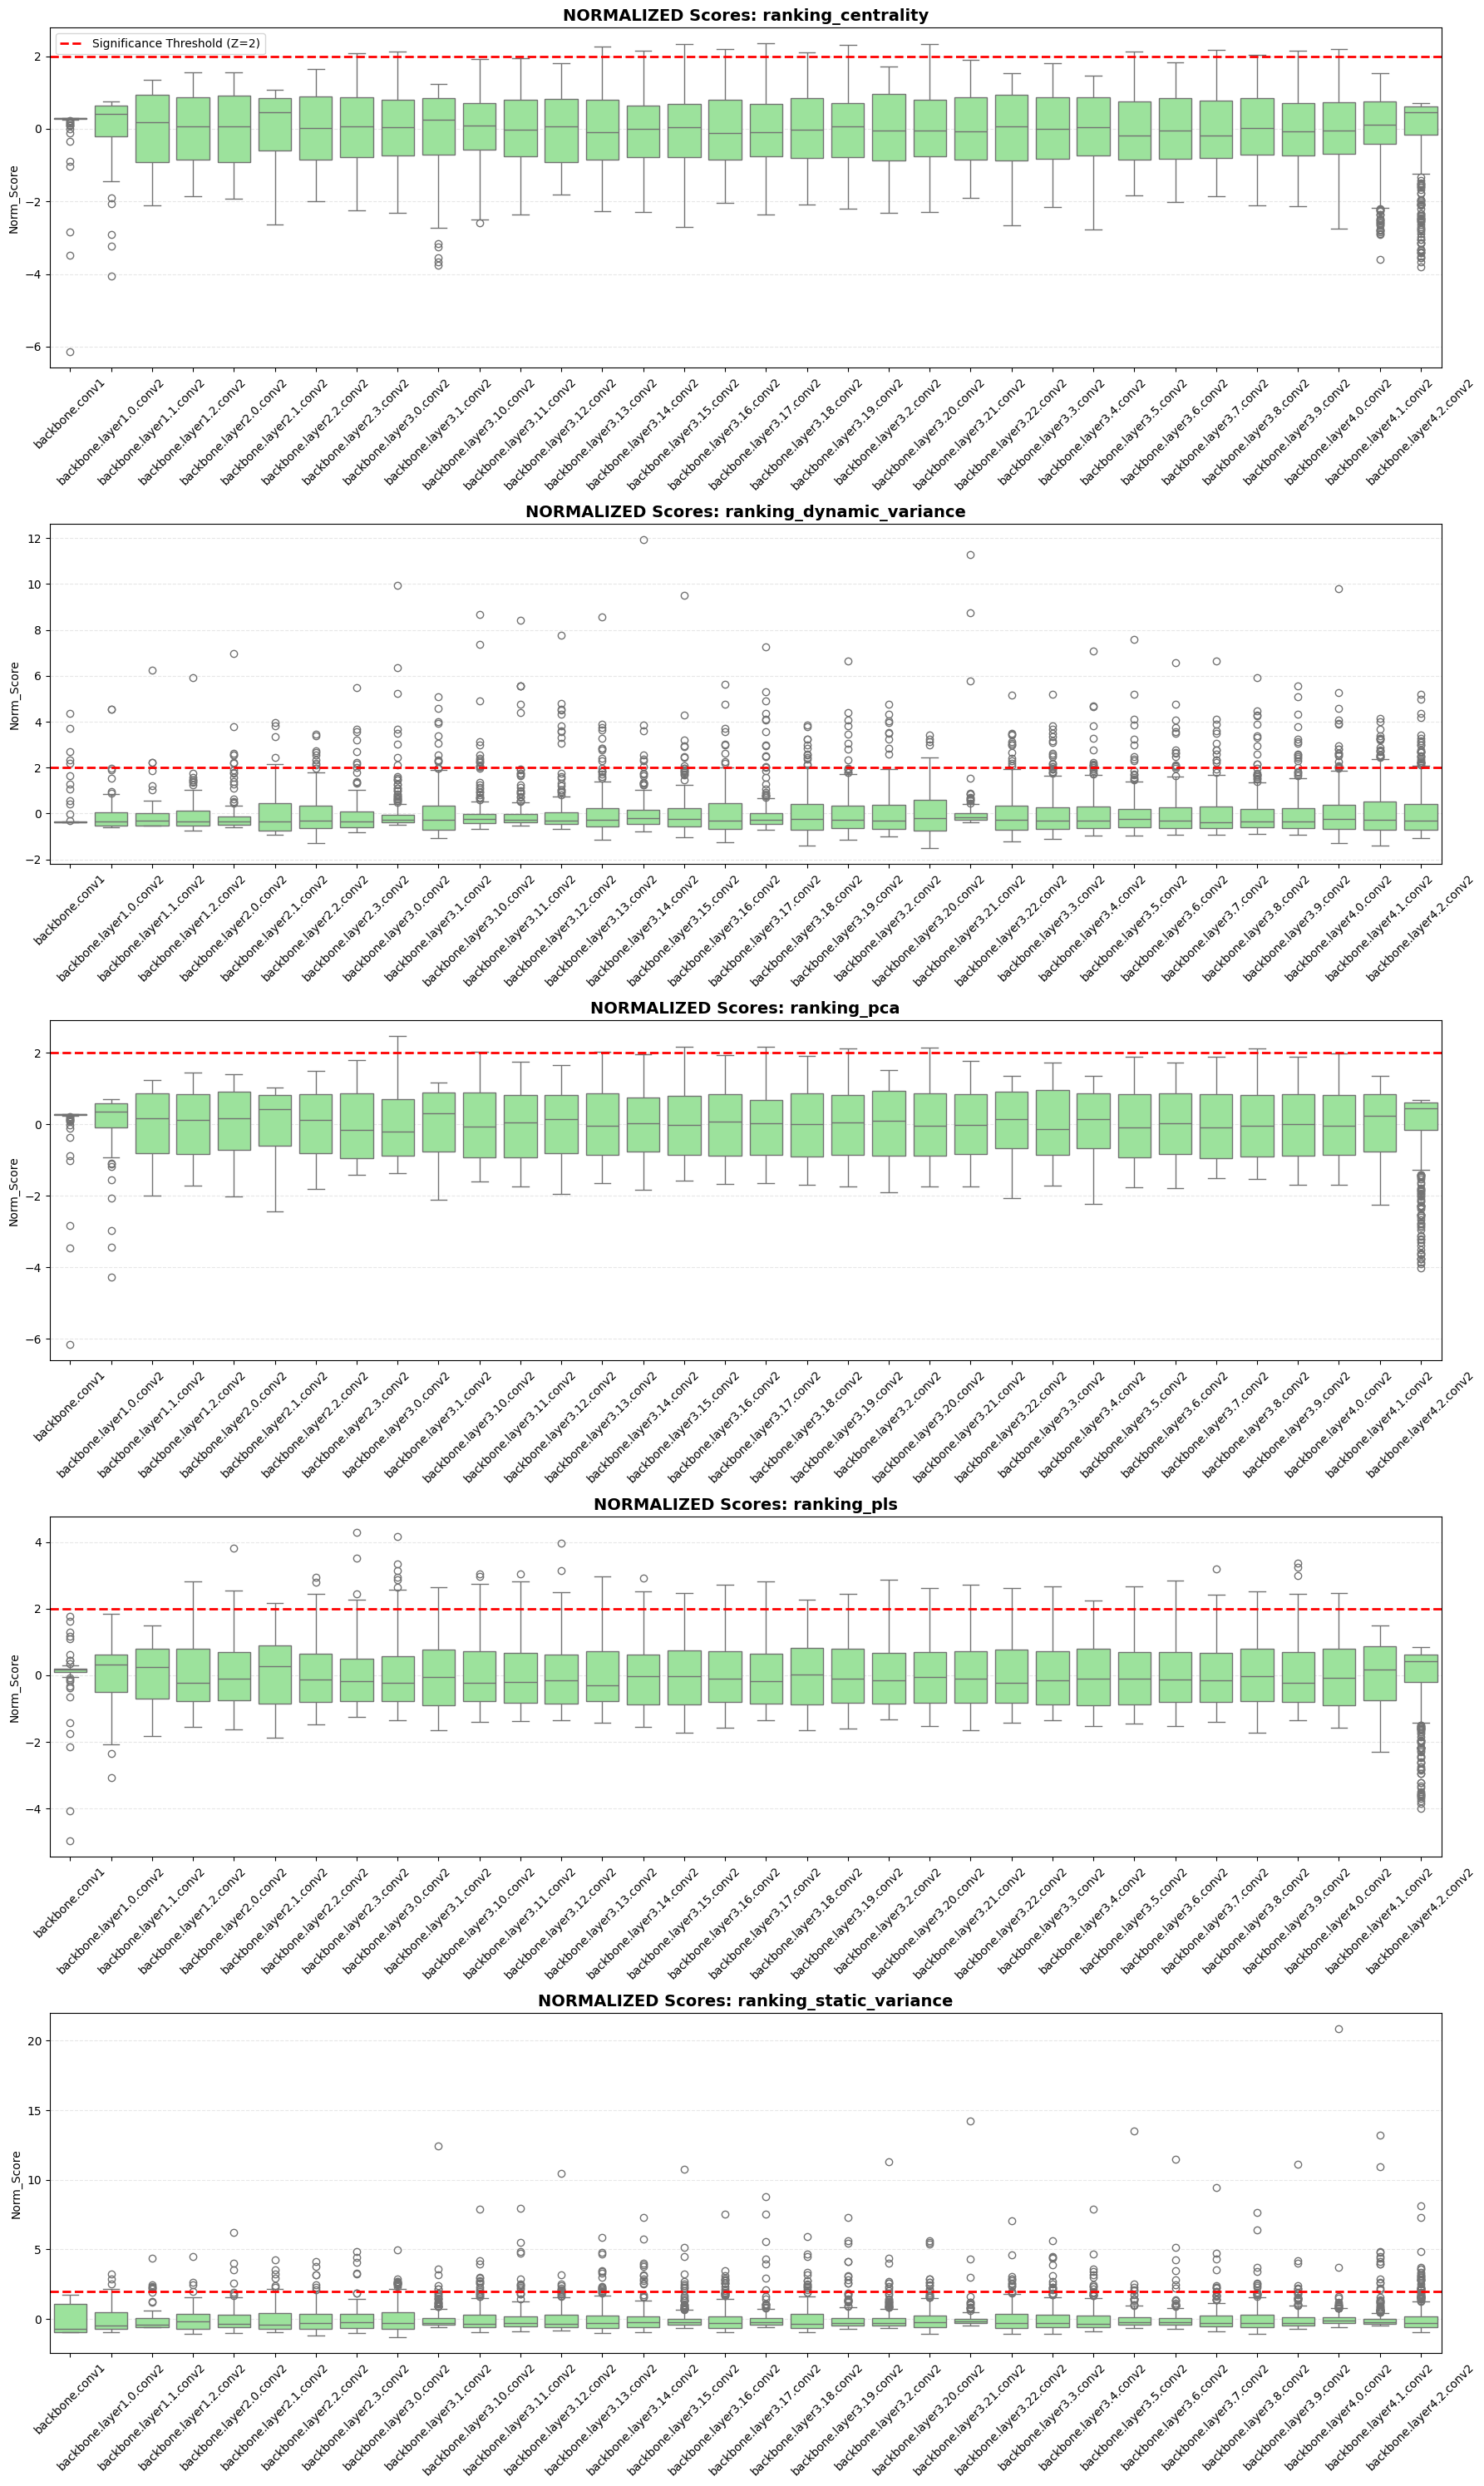

In [3]:
# --- CELL 3: NORMALIZED SCORES ---
fig, axes = plt.subplots(len(metrics), 1, figsize=(18, 6 * len(metrics)))

print("--- NORMALIZED DISTRIBUTIONS (Z-Scores) ---")

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    subset = df_sorted[df_sorted['Metric'] == metric]
    
    sns.boxplot(data=subset, x='Layer', y='Norm_Score', ax=ax, color='lightgreen')
    
    # Add Threshold Line (Z=2 is standard for "Significant")
    ax.axhline(y=2.0, color='red', linestyle='--', linewidth=2, label='Significance Threshold (Z=2)')
    
    ax.set_title(f"NORMALIZED Scores: {metric}", fontsize=14, fontweight='bold')
    ax.tick_params(axis='x', rotation=45)
    ax.grid(True, axis='y', linestyle='--', alpha=0.3)
    ax.set_xlabel("")
    if idx == 0: ax.legend() # Only show legend on top plot

plt.tight_layout()
plt.show()

## Step 2: Are the Metrics Orthogonal? (Jaccard Heatmap)
**Goal:** We want to see the overlap (orthogonality).

Critical thought: We should compare the Top N kernels, try different numbers

--- Calculating Overlap for Top 100 Kernels ---


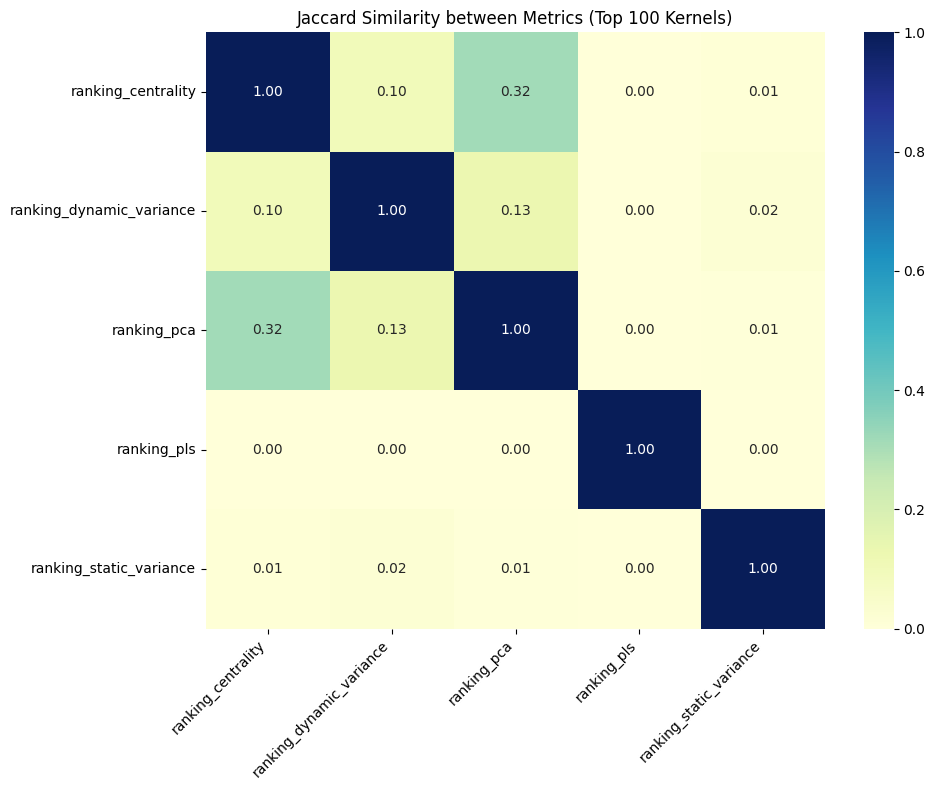

In [4]:
# --- CONFIG ---
K = 100  # <--- CHANGE THIS NUMBER HERE (Try 50, 500, 2000)

def calculate_metric_overlap(df, top_k):
    # Sanity Check: Print what K the function actually sees
    print(f"--- Calculating Overlap for Top {top_k} Kernels ---")
    
    metrics = df['Metric'].unique()
    matrix = np.zeros((len(metrics), len(metrics)))
    
    top_kernels = {}
    for m in metrics:
        # Sort by Norm_Score
        sorted_m = df[df['Metric'] == m].sort_values('Norm_Score', ascending=False)
        
        # Grab Unique IDs
        # We limit the list to [:top_k]
        top_kernels[m] = set(sorted_m['Unique_ID'].values[:top_k])
        
    for i, m1 in enumerate(metrics):
        for j, m2 in enumerate(metrics):
            set1 = top_kernels[m1]
            set2 = top_kernels[m2]
            
            intersection = len(set1.intersection(set2))
            union = len(set1.union(set2))
            
            if union == 0:
                jaccard = 0
            else:
                jaccard = intersection / union
                
            matrix[i, j] = jaccard
            
    return matrix, metrics

# Pass the variable 'K' explicitly
mat, metric_names = calculate_metric_overlap(df, top_k=K)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(mat, annot=True, fmt=".2f", 
            xticklabels=metric_names, yticklabels=metric_names, 
            cmap="YlGnBu", vmin=0, vmax=1)
plt.title(f"Jaccard Similarity between Metrics (Top {K} Kernels)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

--- Calculating Global Correlation between Metrics ---


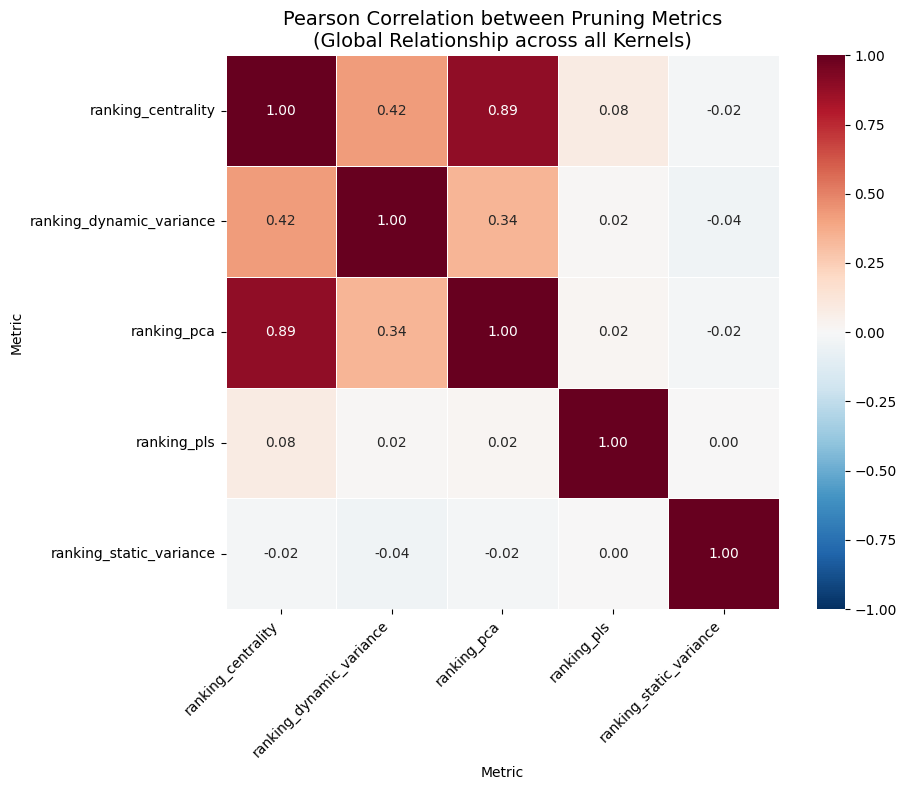

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_metric_correlation(df):
    print("--- Calculating Global Correlation between Metrics ---")
    
    # 1. Pivot the Data
    # We want: Rows = Kernels, Cols = Metrics, Values = Normalized Scores
    # This aligns the scores so we can compare them directly
    pivot_df = df.pivot(index='Unique_ID', columns='Metric', values='Norm_Score')
    
    # 2. Calculate Pearson Correlation
    # This uses ALL ~8000 kernels, giving a robust statistical view
    corr_matrix = pivot_df.corr(method='pearson')
    
    # 3. Plot Heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", 
                cmap="RdBu_r", vmin=-1, vmax=1, center=0,
                square=True, linewidths=.5)
    
    plt.title("Pearson Correlation between Pruning Metrics\n(Global Relationship across all Kernels)", fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    return corr_matrix

# Run it
correlations = plot_metric_correlation(df)

## Step 3: Stability Analysis (Batch Splitting)
Decision on Batches:

Split: 2 Batches.

Size: 350 images each.

Overlap: NO Overlap.

Rationale: We want the "hardest" test possible. If we have overlap (e.g., image #1 is in both Batch A and Batch B), the stability score will artificially inflate because the input data is identical. If we use disjoint sets (Batch A = images 0-350, Batch B = images 351-700), and the metrics still pick the same kernels, that proves the kernels are robust features of the dataset/cancer, not just quirks of specific images.

Testing Stability for: Dynamic Var...
--- Computing Dynamic Variance (Activations) ---
--- Computing Dynamic Variance (Activations) ---
Testing Stability for: PCA...
--- Computing PCA Loadings ---
--- Computing PCA Loadings ---
Testing Stability for: Centrality...
--- Computing Eigenvector Centrality ---
--- Computing Eigenvector Centrality ---
Testing Stability for: PLS...
--- Computing PLS Importance (Supervised) ---
--- Computing PLS Importance (Supervised) ---

--- Stability Scores (Jaccard Index, Top 50) ---
Dynamic Var    : 0.82
PCA            : 0.43
Centrality     : 0.43
PLS            : 0.05


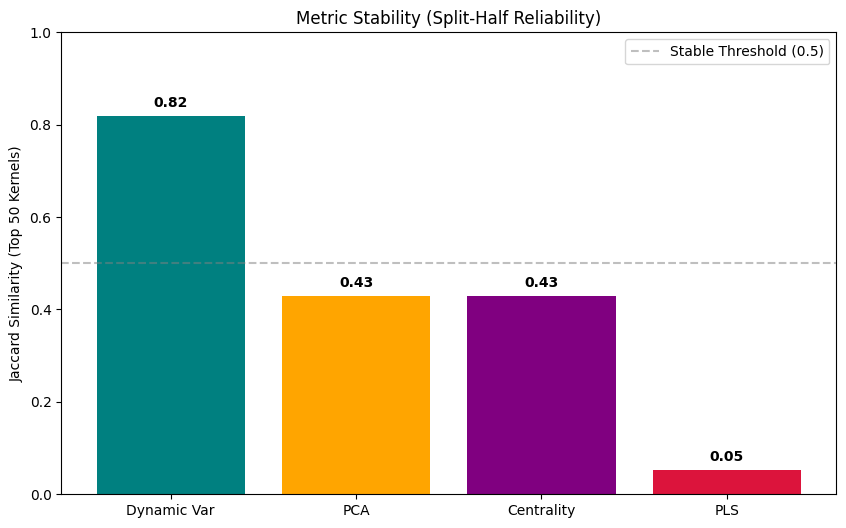

In [6]:
import h5py
import torch
import numpy as np
import matplotlib.pyplot as plt
import sys

# Ensure src is reachable
sys.path.append('../src')
import rankers as rankers

# --- 1. Load Data AND Labels (The Raw "Homework Papers") ---
def get_data_and_labels(h5_path):
    vectors = {}
    labels = None
    with h5py.File(h5_path, 'r') as f:
        # Load IoU Scores (Required for PLS)
        if 'iou_scores' in f:
            labels = f['iou_scores'][:]
            
        # Load Raw Feature Vectors
        for layer in f.keys():
            if layer not in ['iou_scores', 'image_names'] and 'raw_gap' in f[layer]:
                vectors[layer] = f[layer]['raw_gap'][:]
    return vectors, labels

# --- 2. Stability Calculation ---
def calculate_split_stability(metric_name, raw_data, labels, top_k=50):
    print(f"Testing Stability for: {metric_name}...")
    
    # Split Data (50/50)
    n_images = list(raw_data.values())[0].shape[0]
    mid = n_images // 2
    
    # Subset A
    input_a = {l: torch.tensor(v[:mid]) for l, v in raw_data.items()}
    labels_a = labels[:mid] if labels is not None else None
    
    # Subset B
    input_b = {l: torch.tensor(v[mid:]) for l, v in raw_data.items()}
    labels_b = labels[mid:] if labels is not None else None
    
    # --- Execute Metric Function ---
    if metric_name == 'Dynamic Var':
        scores_a = rankers.compute_dynamic_variance(input_a)
        scores_b = rankers.compute_dynamic_variance(input_b)
    elif metric_name == 'PCA':
        scores_a = rankers.compute_pca_loading(input_a)
        scores_b = rankers.compute_pca_loading(input_b)
    elif metric_name == 'Centrality':
        # Note: Centrality can be slow
        scores_a = rankers.compute_eigen_centrality(input_a)
        scores_b = rankers.compute_eigen_centrality(input_b)
    elif metric_name == 'PLS':
        # PLS requires labels!
        scores_a = rankers.compute_pls_importance(input_a, labels_a)
        scores_b = rankers.compute_pls_importance(input_b, labels_b)
    
    # --- Helper to Extract Top K Indices ---
    def get_top_set(scores_dict, k):
        flat = []
        for l, s in scores_dict.items():
            if isinstance(s, torch.Tensor): s = s.numpy()
            # Normalize per layer to treat them equally
            if s.std() > 0:
                s = (s - s.mean()) / s.std()
            
            for ch, val in enumerate(s): 
                flat.append((l, ch, val))
        
        # Sort by score and take top K
        flat.sort(key=lambda x: x[2], reverse=True)
        return set([(x[0], x[1]) for x in flat[:k]])

    # Calculate Jaccard
    top_a = get_top_set(scores_a, top_k)
    top_b = get_top_set(scores_b, top_k)
    
    intersection = len(top_a.intersection(top_b))
    union = len(top_a.union(top_b))
    
    return intersection / union if union > 0 else 0.0

# --- 3. Execution ---
# Load Raw Data
vectors, iou_labels = get_data_and_labels(H5_PATH)

# Run Comparison
metrics_to_test = ['Dynamic Var', 'PCA', 'Centrality', 'PLS']
results = {}

for m in metrics_to_test:
    # We check if the Top 50 "All-Stars" remain the same
    results[m] = calculate_split_stability(m, vectors, iou_labels, top_k=50)

# Print Results
print("\n--- Stability Scores (Jaccard Index, Top 50) ---")
for m, s in results.items():
    print(f"{m:<15}: {s:.2f}")

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(results.keys(), results.values(), color=['teal', 'orange', 'purple', 'crimson'])
plt.ylim(0, 1.0)
plt.axhline(0.5, color='gray', linestyle='--', alpha=0.5, label='Stable Threshold (0.5)')
plt.title("Metric Stability (Split-Half Reliability)")
plt.ylabel("Jaccard Similarity (Top 50 Kernels)")
plt.legend()

# Add values on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.2f}", ha='center', fontweight='bold')

plt.show()

The metric used in the scatter plots is the Pearson Correlation Coefficient (r).

r=1.0: Perfect Stability. If a kernel is strong in Batch A, it is equally strong in Batch B.

r=0.0: Random Noise. The score in Batch A tells you nothing about the score in Batch B.

r<0: Anti-correlated (very bad).

Computing metrics on split batches...
--- Computing Dynamic Variance (Activations) ---
--- Computing Dynamic Variance (Activations) ---
--- Computing PCA Loadings ---
--- Computing PCA Loadings ---
--- Computing Eigenvector Centrality ---
--- Computing Eigenvector Centrality ---
--- Computing PLS Importance (Supervised) ---
--- Computing PLS Importance (Supervised) ---


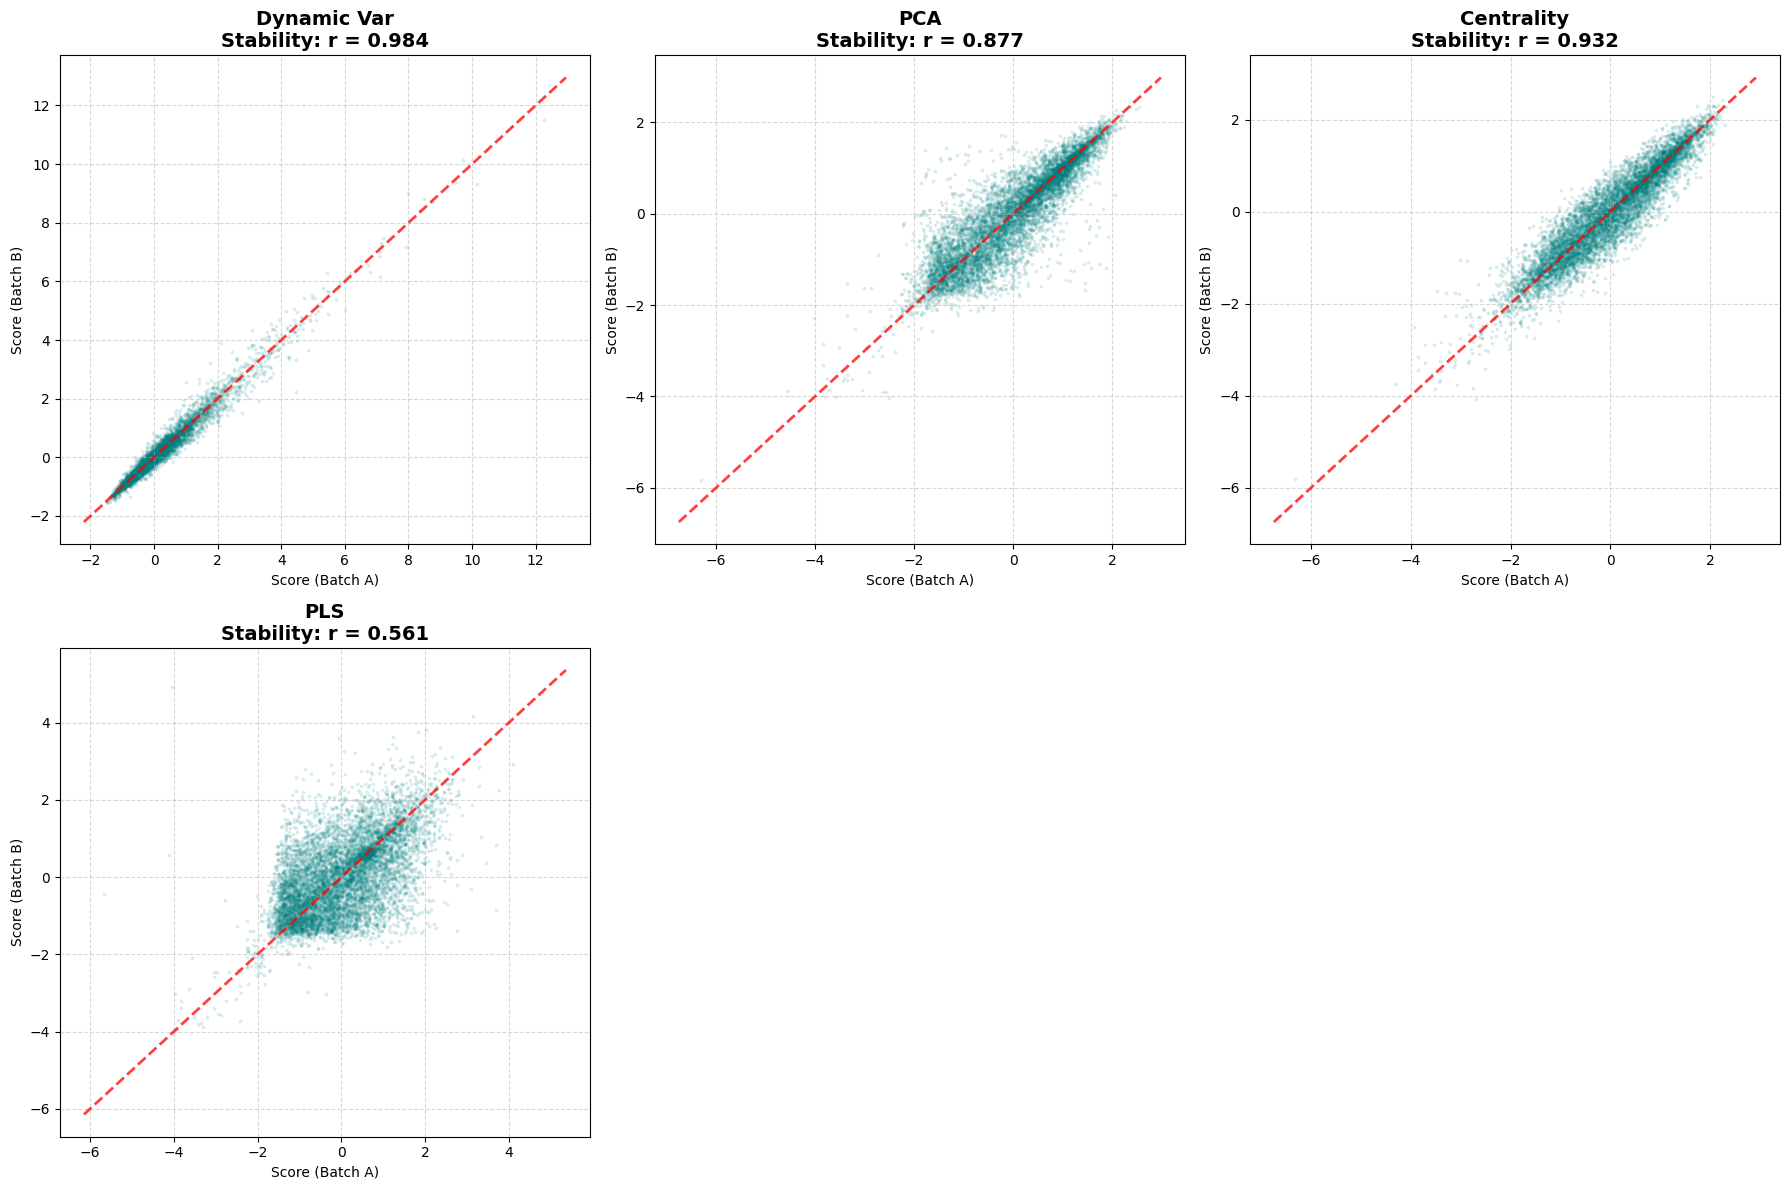

In [7]:
import scipy.stats
import matplotlib.pyplot as plt
import numpy as np
import torch
import sys

# Ensure src is reachable for rankers
sys.path.append('../src')
import rankers as rankers

def plot_all_stability_scatters(raw_data, labels, metrics_list):
    # Setup Figure: 2 Rows, 3 Cols
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten() # Flatten to easy 1D array
    
    # Split Data Once
    n_images = list(raw_data.values())[0].shape[0]
    mid = n_images // 2
    
    input_a = {l: torch.tensor(v[:mid]) for l, v in raw_data.items()}
    input_b = {l: torch.tensor(v[mid:]) for l, v in raw_data.items()}
    
    labels_a = labels[:mid] if labels is not None else None
    labels_b = labels[mid:] if labels is not None else None
    
    print("Computing metrics on split batches...")
    
    for idx, metric_name in enumerate(metrics_list):
        ax = axes[idx]
        
        # --- Run Metric ---
        scores_a, scores_b = {}, {}
        
        if metric_name == 'Dynamic Var':
            scores_a = rankers.compute_dynamic_variance(input_a)
            scores_b = rankers.compute_dynamic_variance(input_b)
        elif metric_name == 'PCA':
            scores_a = rankers.compute_pca_loading(input_a)
            scores_b = rankers.compute_pca_loading(input_b)
        elif metric_name == 'Centrality':
            scores_a = rankers.compute_eigen_centrality(input_a)
            scores_b = rankers.compute_eigen_centrality(input_b)
        elif metric_name == 'PLS':
            if labels is None: continue
            scores_a = rankers.compute_pls_importance(input_a, labels_a)
            scores_b = rankers.compute_pls_importance(input_b, labels_b)

        # --- Flatten & Normalize ---
        list_a, list_b = [], []
        
        for layer in scores_a.keys():
            sa = scores_a[layer]
            sb = scores_b[layer]
            
            if isinstance(sa, torch.Tensor): sa = sa.numpy()
            if isinstance(sb, torch.Tensor): sb = sb.numpy()
            
            # Z-Score Normalization per layer (Critical for fair comparison)
            if sa.std() > 0: sa = (sa - sa.mean()) / sa.std()
            if sb.std() > 0: sb = (sb - sb.mean()) / sb.std()
            
            list_a.extend(sa)
            list_b.extend(sb)
            
        # --- Plotting ---
        # Scatter Plot with transparency
        ax.scatter(list_a, list_b, alpha=0.1, s=3, c='teal')
        
        # Calculate Pearson Correlation
        corr, _ = scipy.stats.pearsonr(list_a, list_b)
        
        # Style
        ax.set_title(f"{metric_name}\nStability: r = {corr:.3f}", fontsize=14, fontweight='bold')
        ax.set_xlabel("Score (Batch A)")
        ax.set_ylabel("Score (Batch B)")
        ax.grid(True, linestyle='--', alpha=0.5)
        
        # Add Red Diagonal Line (Ideal Stability)
        lims = [np.min([ax.get_xlim(), ax.get_ylim()]), np.max([ax.get_xlim(), ax.get_ylim()])]
        ax.plot(lims, lims, 'r--', alpha=0.75, linewidth=2)

    # Hide unused subplots (we have 4 metrics, grid has 6 slots)
    for i in range(len(metrics_list), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

# --- Execution ---
# Define the metrics we want to test
metrics_to_plot = ['Dynamic Var', 'PCA', 'Centrality', 'PLS']

# Run the plotter
# (Assuming 'vectors' and 'iou_labels' are loaded from previous cells)
plot_all_stability_scatters(vectors, iou_labels, metrics_to_plot)